In [57]:
def theta_ft(h,ft_intercept,gamma):
    """
       input h (meters) and the coefficients for the linear
       profile for the free troposphere theta (ft_intercept (K)  and slope gamma (K/m))
       return the free tropospher theta at height h
    """
    theta_top = ft_intercept + h*gamma
    return theta_top

#
# helper function to turn a dictionary into a named tuple
#
from collections import namedtuple
def make_tuple(tupname,in_dict):
    the_tup = namedtuple(tupname, in_dict.keys())
    the_tup = the_tup(**in_dict)
    return the_tup

In [58]:
%matplotlib inline
import numpy as np
import scipy.integrate as integrate
from matplotlib import pyplot as plt
import pandas as pd
import thermlib
from importlib import reload
reload(thermlib)
from thermlib import thermfuncs as tf



def dmixed_vars(the_vars,tstep,coeffs):
    """
      the_vars[0]= thetabar
      the_vars[1] = h
      the_vars[2] = qv
      
      surface flux from drag law with subsidence and diagnosed deltheta
    """
    #print('the_vars: ',the_vars,D,U)
    deltheta = theta_ft(the_vars[1],coeffs.ft_intercept,coeffs.ft_gamma) - the_vars[0]
    F0 = coeffs.U*coeffs.Cd*(coeffs.sst - the_vars[0])  #surface heat flux
    Fqv0 = coeffs.U*coeffs.Cd*(coeffs.qsfc - the_vars[2])  #surface vapor flux
    Fint = -coeffs.k*F0  #entrainment heat flux
    went = -Fint/deltheta  #entrainment velocity (positive upward)
    Fqvent = -went*( coeffs.ft_qv - the_vars[2])
    wsubs = -coeffs.D*the_vars[1]
    rho=1.
    cp=1004.
    derivs=np.empty_like(the_vars)
    derivs[0]=(F0 - Fint)/(the_vars[1]*rho) - 30./1004./the_vars[1]
    derivs[1] = went + wsubs
    derivs[2] = (Fqv0 - Fqvent)/the_vars[1]
    return derivs

In [59]:
reload(thermlib)
from thermlib import thermfuncs as tf
dtout=10.  #minutes
end_time=8*24.   #hours
del_time=dtout*60. #seconds
end_time=end_time*3600. #seconds
sst=297
D=5.e-6  #s-1
U=7  #m/s
psfc=100. #kPa
qsfc=tf.qs_tp(sst,psfc)
ft_intercept = 292 #K
ft_gamma = 6.e-3  #K/m
ft_qv = 2.e-3
k=0.6  #entrainment efficiency
Cd = 1.e-3  #drag coefficient
tspan = np.arange(0.,end_time,del_time)
vars_init=[285.,400.,8.e-3]  #theta (K), height (m) qv (kg/kg) to start
the_tup=dict(D=D,U=U,sst=sst,ft_intercept=ft_intercept,ft_gamma=ft_gamma,
             qsfc=qsfc,ft_qv=ft_qv,k=k,Cd=Cd)
the_tup=make_tuple('coeffs',the_tup)
output=integrate.odeint(dmixed_vars, vars_init, tspan,(the_tup,))
result=pd.DataFrame.from_records(output,columns=['theta','h','qv'])
result['time']=tspan/3600./24.  #days
result['deltheta'] = theta_ft(result['h'].values,ft_intercept,ft_gamma) - result['theta']

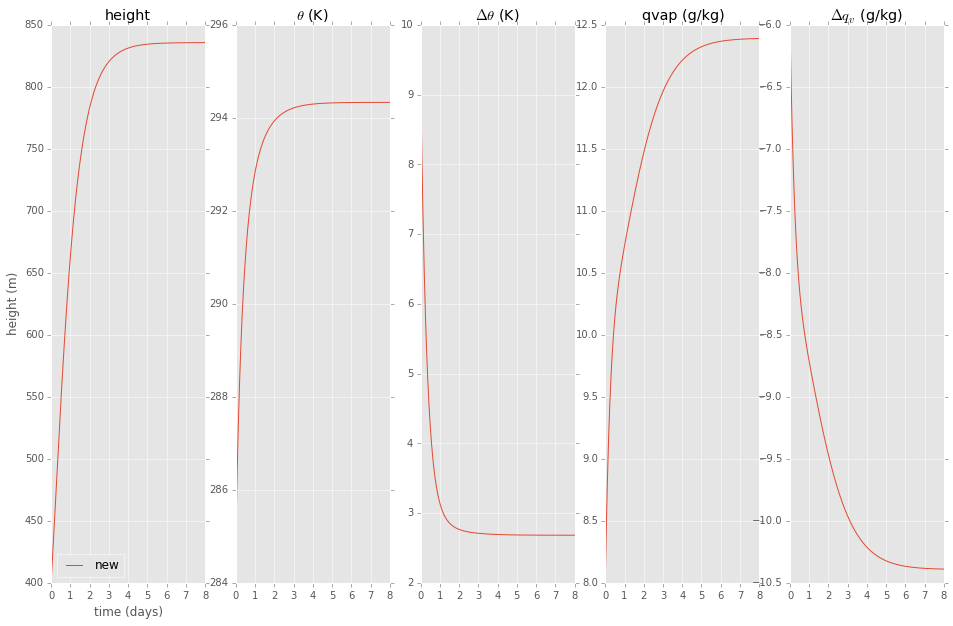

In [60]:
%matplotlib inline
plt.close('all')
plt.style.use('ggplot')
fig,ax = plt.subplots(1,5,figsize=(16,10))
ax[0].plot(result['time'],result['h'],label='new')
ax[0].set(ylabel='height (m)',xlabel='time (days)',title='height')
ax[0].legend(loc='best')
ax[1].plot(result['time'],result['theta'],label='new')
out=ax[1].set(title=r'$\theta$ (K)')
out=ax[2].plot(result['time'],result['deltheta'],label='new')
out=ax[2].set(title=r'$\Delta \theta$ (K)')
out=ax[3].plot(result['time'],result['qv']*1.e3,label='new')
out=ax[3].set(title='qvap (g/kg)')
result['delqv'] = ft_qv - result['qv']
out=ax[4].plot(result['time'],result['delqv']*1.e3)
out=ax[4].set(title=r'$\Delta q_v$ (g/kg)')

In [63]:
reload(thermlib)
from thermlib import thermfuncs as tf
def calc_lcl(row,psfc):
    """
      find the lcl (in m) for a row in the dataframe
    """
    Tdew = tf.tmr(row['qv'],psfc)
    LCL = tf.LCL(Tdew,row['theta'],psfc)  #kPa
    #
    # rough approximation:  10 kPa = 1 km
    #
    delp=psfc - LCL
    lcl_h = delp*100.
    return lcl_h


def calc_sfc_theta_flux(row,coeffs):
    F0 = coeffs.U*coeffs.Cd*(coeffs.sst - row['theta'])  #surface heat flux
    return F0

def calc_sfc_qvap_flux(row,coeffs):
    Fqv0 = coeffs.U*coeffs.Cd*(coeffs.qsfc - row['qv'])
    return Fqv0

def calc_entflux_theta(row,coeffs):
    flux_ent = -coeffs.k*row['T_flux_0']
    return flux_ent

def calc_went(row,coeffs):
    went = -row['entflux_theta']/row['deltheta']
    return went
    
def calc_entflux_qv(row,coeffs):
    flux_ent =  -row['went']*( coeffs.ft_qv - row['qv'])
    return flux_ent


result['LCL']=result.apply(calc_lcl,axis=1,args=(psfc,))
result['q_flux_0']=result.apply(calc_sfc_qvap_flux,axis=1,args=(the_tup,))
result['T_flux_0']=result.apply(calc_sfc_theta_flux,axis=1,args=(the_tup,))  
result['thick'] = result['h'] - result['LCL']
result['entflux_theta']=result.apply(calc_entflux_theta,axis=1,args=(the_tup,))
result['went'] = result.apply(calc_went,axis=1,args=(the_tup,))
result['entflux_qv']=result.apply(calc_entflux_qv,axis=1,args=(the_tup,))

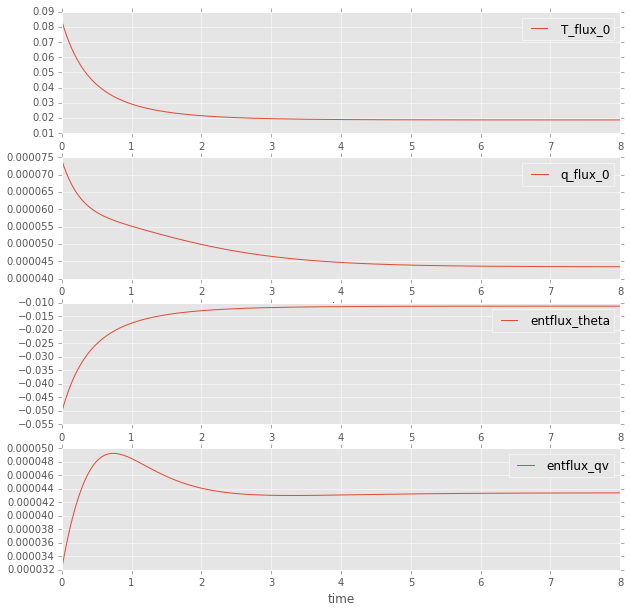

In [74]:
fig,ax=plt.subplots(4,1,figsize=(10,10))
result.plot('time','T_flux_0',ax=ax[0])
result.plot('time','q_flux_0',ax=ax[1])
result.plot('time','entflux_theta',ax=ax[2])
out=result.plot('time','entflux_qv',ax=ax[3])

# Calculate and plot w*

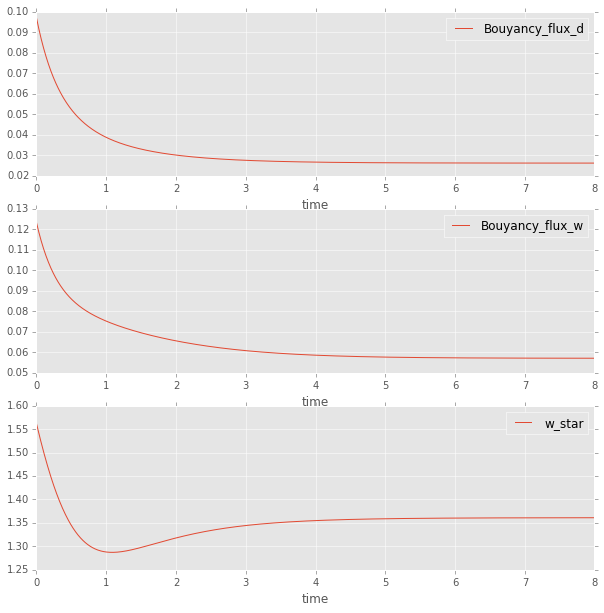

In [87]:
def bouyancy_flux_d (row,coeffs):
    w_thetav = 1.01*row['T_flux_0'] + 170*row['q_flux_0']
    return w_thetav
def bouyancy_flux_w(row,coeffs):
    w_thetav = 0.5*row['T_flux_0'] + 1100*row['q_flux_0']
    return w_thetav

def w_star(row,coeffs):
    w_star=((row['Bouyancy_flux_d']*row['LCL']+row['Bouyancy_flux_w']*row['thick'])*9.8/row['theta']*(2.5))**(1/3)
    return w_star
    
    
    
result['Bouyancy_flux_d'] = result.apply(bouyancy_flux_d,axis=1,args=(the_tup,))
result['Bouyancy_flux_w'] = result.apply(bouyancy_flux_w,axis=1,args=(the_tup,))
result['w_star'] = result.apply(w_star,axis=1,args=(the_tup,))

fig,ax=plt.subplots(3,1,figsize=(10,10))
result.plot('time','Bouyancy_flux_d',ax=ax[0])
result.plot('time','Bouyancy_flux_w',ax=ax[1])
result.plot('time','w_star',ax=ax[2])




In [88]:
result

,theta,h,qv,time,deltheta,delqv,LCL,q_flux_0,T_flux_0,thick,entflux_theta,went,entflux_qv,Bouyancy_flux,Bouyancy_flux_d,Bouyancy_flux_w,w_star
0,285.000000,400.000000,0.008000,0.000000,9.400000,-0.006000,192.075118,0.000074,0.084000,207.924882,-0.050400,0.005362,0.000032,0.097449,0.097449,0.123590,1.562970
1,285.155085,402.017731,0.008062,0.006944,9.257022,-0.006062,197.841685,0.000074,0.082914,204.176047,-0.049749,0.005374,0.000033,0.096279,0.096279,0.122568,1.558670
2,285.306834,404.036864,0.008123,0.013889,9.117387,-0.006123,203.647000,0.000073,0.081852,200.389864,-0.049111,0.005387,0.000033,0.095134,0.095134,0.121570,1.554396
3,285.455328,406.057363,0.008182,0.020833,8.981016,-0.006182,209.482706,0.000073,0.080813,196.574657,-0.048488,0.005399,0.000033,0.094014,0.094014,0.120595,1.550148
4,285.600664,408.079190,0.008240,0.027778,8.847811,-0.006240,215.341469,0.000072,0.079795,192.737721,-0.047877,0.005411,0.000034,0.092917,0.092917,0.119642,1.545928
5,285.742922,410.102306,0.008296,0.034722,8.717692,-0.006296,221.216352,0.000072,0.078800,188.885954,-0.047280,0.005423,0.000034,0.091845,0.091845,0.118711,1.541736
6,285.882177,412.126668,0.008351,0.041667,8.590583,-0.006351,227.101014,0.000072,0.077825,185.025655,-0.046695,0.005436,0.000035,0.090795,0.090795,0.117802,1.537575
7,286.018510,414.152234,0.008404,0.048611,8.466404,-0.006404,232.989699,0.000071,0.076870,181.162534,-0.046122,0.005448,0.000035,0.089768,0.089768,0.116913,1.533444
8,286.151992,416.178954,0.008456,0.055556,8.345081,-0.006456,238.877126,0.000071,0.075936,177.301828,-0.045562,0.005460,0.000035,0.088762,0.088762,0.116044,1.529345
9,286.282700,418.206781,0.008507,0.062500,8.226541,-0.006507,244.758505,0.000071,0.075021,173.448276,-0.045013,0.005472,0.000036,0.087777,0.087777,0.115195,1.525279


# How to calculate h in meters

## Use pressure levels and Invert Thetal to get temp, vapor, & liquid

    Result = tf.t_uos_thetal(thetal,qvap,P)
    
## Use this to convert to virtual temperature

    Tv = Resutl['T']*(1+Resutl['rv']/.61)/(1+.61)

## Use the ideal gas law with Tv instead of T to calculate a rho profile

    rho_profile = Rd*Tv/P
    
## Calculate the ratio of rho_surface to the rho profile

    ratio_profile = rho_profile/rho_surface
  
## Use the relationship 10 kpa ~ 1 km & the ratio profile to calculate a height
 ### Loop through pressure levels, calculate a thickness of each level, & create a cumlative sum
    Hsum = 0
    for i in range(0,len(P):
        Del_P = P[i]-P[i+1]
        Thickness = ratio_profile[i]*Del_P*(100)
        Height[i] = Thickness+Hsum
        Hsum = Height[i]
       
# This may not work very well once in the actual cloud layer
## The liquid water may throw the ideal gas law out of whack